In [1]:
import email
import csv
import re
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.precision = 18

_Note: 
It would be better to have written this as a class to be more elegant and time-space effective but for illustration purposes, the code was shown like this so that the construction of the classifier can be seen as I was progressing through the assignment_ 

## Data Preprocessing

Retrieving the labels and getting the test labels

In [2]:
df_labels = pd.read_csv('trec06p-cs280\\labels', sep = ' ', names = ['class', 'file'])
df_train_labels = df_labels.iloc[:df_labels.loc[df_labels['file'] == '../data/071/000'].index[0],:]

Defining the functions that parse the emails and converts them to the desired format

In [3]:
# Creates a list of emails that were converted to lists while preserving word order 
# Also locally saves the list as a CSV file for future use
def generate_list_of_emails_as_word_list(directory, train_data = True):
    emails = []
    ### If generating the list of emails of the training data
    if train_data:
        ham = []
        spam = []
        for i in range(71):
            print("Loading Folder #" + str(i))
            for j in range(300):
                sample = open(directory + ("%03d" % i) + "\\" + ("%03d" % j))
                text = sample.read()
                parsed_email = retrieve_body_from_email_as_word_list(text)
                emails.append(parsed_email)
                if (df_train_labels[df_train_labels['file'] == '../data/' + ("%03d" % i) + "/" + ("%03d" % j)]['class'].values[0] == 'ham'):
                    ham.append(parsed_email)
                else:
                    spam.append(parsed_email)
            
    
        with open("email_body_words.csv", "wb") as f:
            writer = csv.writer(f)
            writer.writerows(emails)
        with open("ham_email_body_words.csv", "wb") as f:
            writer = csv.writer(f)
            writer.writerows(ham)
        with open("spam_email_body_words.csv", "wb") as f:
            writer = csv.writer(f)
            writer.writerows(spam)
        print("Successfully loaded and locally saved!")
        return {'all': emails, 'ham': ham, 'spam': spam}
    #### If generating the list of emails of the test data
    else:
        for i in range(71,126):
            print("Loading Folder #" + str(i))
            for j in range(300):
                sample = open(directory + ("%03d" % i) + "\\" + ("%03d" % j))
                text = sample.read()
                parsed_email = retrieve_body_from_email_as_word_list(text)
                emails.append(parsed_email)
        return emails
# Retrieve the body from emails
def retrieve_body_from_email_as_word_list(text):
    b = email.message_from_string(text)
    body = ""
    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
    
            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                break
    # not multipart - i.e. plain text, no attachments
    else:
        body = b.get_payload(decode=True)
    return clean_and_get_alphabet_only_strings(body.split())

# From the list of words extracted from the email, only take strings that follow these conditions: 
# (Lifted from the specifications)
# 1. Completely of alphabet characters
# 2. Has a whitespace in front
# 3. Has a whitespace, comma, or period at the end
def clean_and_get_alphabet_only_strings(word_list):
    return [word.lower().rstrip(',').rstrip('.') for word in word_list if re.match('^[a-zA-Z]+$', word.rstrip(',').rstrip('.'))]

Run the user-defined functions to complete the preprocessing

In [4]:
%%time
# Generate the list containing lists of words per email in the training set
dict_emails = generate_list_of_emails_as_word_list("trec06p-cs280\\data\\")
all_emails = dict_emails['all']
ham_emails = dict_emails['ham']
spam_emails = dict_emails['spam']

Loading Folder #0
Loading Folder #1
Loading Folder #2
Loading Folder #3
Loading Folder #4
Loading Folder #5
Loading Folder #6
Loading Folder #7
Loading Folder #8
Loading Folder #9
Loading Folder #10
Loading Folder #11
Loading Folder #12
Loading Folder #13
Loading Folder #14
Loading Folder #15
Loading Folder #16
Loading Folder #17
Loading Folder #18
Loading Folder #19
Loading Folder #20
Loading Folder #21
Loading Folder #22
Loading Folder #23
Loading Folder #24
Loading Folder #25
Loading Folder #26
Loading Folder #27
Loading Folder #28
Loading Folder #29
Loading Folder #30
Loading Folder #31
Loading Folder #32
Loading Folder #33
Loading Folder #34
Loading Folder #35
Loading Folder #36
Loading Folder #37
Loading Folder #38
Loading Folder #39
Loading Folder #40
Loading Folder #41
Loading Folder #42
Loading Folder #43
Loading Folder #44
Loading Folder #45
Loading Folder #46
Loading Folder #47
Loading Folder #48
Loading Folder #49
Loading Folder #50
Loading Folder #51
Loading Folder #52
Loa

## Classifier Construction

### Forming the vocabulary of unique words and its statistics

Defining the function that generates the vocabulary V

In [5]:
# Joins all the lists and then creates one big list of words from all emails
# and then creates a dictionary of unique words along with their counts
# Also locally saves the vocabulary for future use
def generate_vocabulary(list_of_lists):
    vocabulary = {}
    all_words = list(itertools.chain.from_iterable(list_of_lists))
    for word in all_words:
        if word in vocabulary:
            vocabulary[word] += 1
        else:
            vocabulary[word] = 1
    df_vocabulary = pd.DataFrame.from_dict(vocabulary, orient='index', columns=['count'])
    df_vocabulary.to_csv('vocabulary.csv')
    print("Vocabulary generated with " + str(len(vocabulary)) + " words")
    return df_vocabulary.sort_values(by=['count'], ascending=False)

In [6]:
# Generate the vocabulary
vocabulary = generate_vocabulary(all_emails)

Vocabulary generated with 51423 words


<BarContainer object of 50 artists>

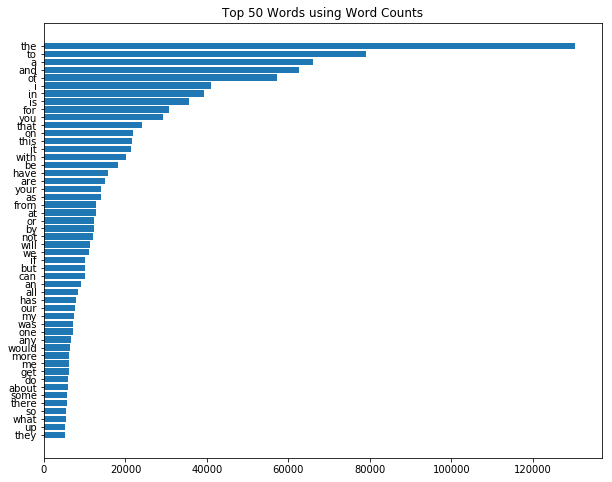

In [7]:
plt.figure(figsize=(10,8))
plt.title("Top 50 Words using Word Counts")
plt.barh(vocabulary[:50].sort_values(by='count', ascending=True).index,vocabulary[:50].sort_values(by='count',ascending=True)['count'].values)

<BarContainer object of 50 artists>

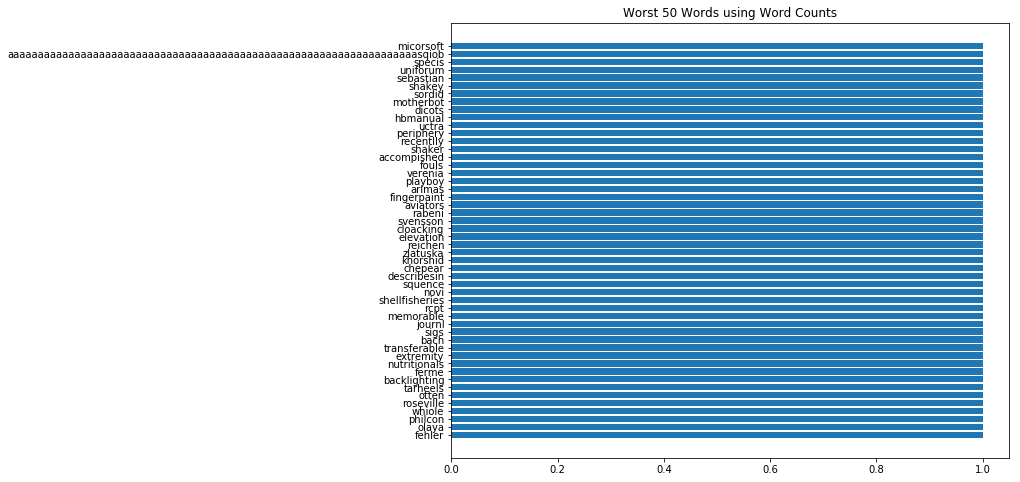

In [8]:
plt.figure(figsize=(10,8))
plt.title("Worst 50 Words using Word Counts")
plt.barh(vocabulary[len(vocabulary)-50:].sort_values(by='count', ascending=False).index,vocabulary[len(vocabulary)-50:].sort_values(by='count',ascending=False)['count'].values)

### Training the Naive Bayes Classifier

Define the function that retrieves the prior probabilities of HAM and SPAM

In [9]:
def get_prior_probability_of_classes(labels):
    df_class_counts = labels['class'].value_counts()
    total_counts = df_class_counts.sum()
    prior_probabilities = {'ham': df_class_counts['ham'] / float(total_counts), 'spam': df_class_counts['spam'] / float(total_counts)}
    return prior_probabilities

Define the training function and sentence vector converter

In [10]:
def train_naive_bayes(ham_emails, spam_emails, vocabulary, labels, n_words, lambda_value):
    ham_sentence_vectors = {}
    spam_sentence_vectors = {}
    
    n_vocabulary = vocabulary[:n_words]
    n_vocabulary_index = n_vocabulary.index
    
    for i in range(len(ham_emails)):
        ham_sentence_vectors[i] = sentence_vector_converter(ham_emails[i], n_vocabulary, n_words)
    ham_sentence_vectors['lambda'] = [lambda_value] * n_words
    
    for i in range(len(spam_emails)):
        spam_sentence_vectors[i] = sentence_vector_converter(spam_emails[i], n_vocabulary, n_words)
    spam_sentence_vectors['lambda'] = [lambda_value] * n_words
       
    # Creates a dataframe from the previous dictionaries that represents the classes as a matrix for easy computation
    df_ham_sentence_vectors = pd.DataFrame(ham_sentence_vectors, index = n_vocabulary_index)
    df_spam_sentence_vectors = pd.DataFrame(spam_sentence_vectors, index = n_vocabulary_index)
    
    # Compute for the probabilities of each word
    naive_bayes_model = pd.concat([df_ham_sentence_vectors.sum(1).to_frame().div(float(len(ham_emails)) + (lambda_value * n_words)), df_spam_sentence_vectors.sum(1).to_frame().div(float(len(spam_emails)) + (lambda_value * n_words))], axis = 1)
    naive_bayes_model.columns = ['ham_probabilities', 'spam_probabilities']
    
    # Get the prior probabilities for each class
    class_prior_probabilities = get_prior_probability_of_classes(labels)
    
    return {'model': naive_bayes_model, 'prior_probabilities': class_prior_probabilities}
    
def sentence_vector_converter(email_word_list, vocabulary, n_words):
    list_vocabulary = vocabulary.index
    sentence_vector = [0] * n_words
    email_word_list = set(email_word_list)
    for word in email_word_list:
        if word in list_vocabulary:
            sentence_vector[list_vocabulary.get_loc(word)] = 1
    return sentence_vector

Define the function that predicts unknown messages

In [11]:
def predict_email(email, naive_bayes_model, vocabulary, n_words):
    if type(email) == str: 
        email_word_list = retrieve_body_from_email_as_word_list(string_email)
    elif type(email) == list:
        email_word_list = email
    sentence_vector = sentence_vector_converter(email_word_list, vocabulary, n_words)
    
    spam_likelihood = 0
    ham_likelihood = 0
    evidence = 0
    
    conditional_probabilities = naive_bayes_model['model']
    ham_conditional_probabilities = conditional_probabilities['ham_probabilities']
    spam_conditional_probabilities = conditional_probabilities['spam_probabilities']

    # Get the probability of the presence or absence of a word given a class in the dictionary 
    for i in range(n_words):
        if sentence_vector[i] == 1:
            word_given_ham = ham_conditional_probabilities.values[i]
            word_given_spam = spam_conditional_probabilities.values[i]
        else:
            word_given_ham = 1 - ham_conditional_probabilities.values[i]
            word_given_spam = 1 - spam_conditional_probabilities.values[i]
        
        # Summation of the logarithm of the probabilities
        ham_likelihood = ham_likelihood + np.log(word_given_ham)
        spam_likelihood = spam_likelihood + np.log(word_given_spam)
        
    # Exponentiate to get the actual probability
    ham_likelihood = np.exp(ham_likelihood)
    spam_likelihood = np.exp(spam_likelihood)
    
    ### Naive Bayes Formula
    # Multiplying the likelihood and the prior probability
    ham_likelihood_times_prior = ham_likelihood * naive_bayes_model['prior_probabilities']['ham']
    spam_likelihood_times_prior = spam_likelihood * naive_bayes_model['prior_probabilities']['spam']
    
    # Compute for the evidence
    evidence = (ham_likelihood_times_prior) + (spam_likelihood_times_prior)
    
    # The probability that the email is a spam or ham 
    ham_probability = ham_likelihood_times_prior / evidence
    spam_probability = spam_likelihood_times_prior / evidence

    if (spam_probability > ham_probability):
        return 'spam'
    return 'ham'

Defining the function for calculating accuracy, precision, and recall

In [12]:
def classifier_evaluation(predicted_labels, true_labels):
    true_positive = 0.0
    true_negative = 0.0
    false_positive = 0.0
    false_negative = 0.0
    
    correct = 0.0
    error = 0.0
    
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == true_labels[i]:
            correct += 1
            if predicted_labels[i] == 'spam':
                true_positive += 1
            else:
                true_negative += 1
        else:
            error += 1
            if predicted_labels[i] == 'spam':
                false_positive += 1
            else:
                false_negative += 1
                
    return {'accuracy': correct/(correct + error), 'recall': true_positive/(true_positive + false_positive), 'precision': true_positive/(true_positive + false_negative)}

## Classifier Evaluation

### Preprocessing the test data

In [13]:
%%time
df_test_labels = df_labels.iloc[df_labels.loc[df_labels['file'] == '../data/071/000'].index[0]:,:]
test_emails = generate_list_of_emails_as_word_list("trec06p-cs280\\data\\", False)

Loading Folder #71
Loading Folder #72
Loading Folder #73
Loading Folder #74
Loading Folder #75
Loading Folder #76
Loading Folder #77
Loading Folder #78
Loading Folder #79
Loading Folder #80
Loading Folder #81
Loading Folder #82
Loading Folder #83
Loading Folder #84
Loading Folder #85
Loading Folder #86
Loading Folder #87
Loading Folder #88
Loading Folder #89
Loading Folder #90
Loading Folder #91
Loading Folder #92
Loading Folder #93
Loading Folder #94
Loading Folder #95
Loading Folder #96
Loading Folder #97
Loading Folder #98
Loading Folder #99
Loading Folder #100
Loading Folder #101
Loading Folder #102
Loading Folder #103
Loading Folder #104
Loading Folder #105
Loading Folder #106
Loading Folder #107
Loading Folder #108
Loading Folder #109
Loading Folder #110
Loading Folder #111
Loading Folder #112
Loading Folder #113
Loading Folder #114
Loading Folder #115
Loading Folder #116
Loading Folder #117
Loading Folder #118
Loading Folder #119
Loading Folder #120
Loading Folder #121
Loading F

### Declaring training variables

In [14]:
vocabulary_words = 10000
n_vocabulary = vocabulary[:vocabulary_words]
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]

### Training the Naive Bayes Classifier with different lambda values

In [15]:
%%time
## Training the model using all lambda values
models = []
for value in lambda_values:
    models.append(train_naive_bayes(ham_emails, spam_emails, n_vocabulary, df_train_labels, vocabulary_words, value))

Wall time: 9min 44s


### Running the model on the test data

In [16]:
%%time
test_results = []
for model in models:
    test_results.append([predict_email(email, model, n_vocabulary, vocabulary_words) for email in test_emails])

C:\Users\Jessie\Anaconda2\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jessie\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


Wall time: 1h 18min 10s


### Evaluating model performance

In [17]:
evaluations = []
true_labels = df_test_labels['class'].values.tolist()

for result in test_results:
    evaluations.append(classifier_evaluation(result, true_labels))

df_model_performance = pd.DataFrame(evaluations, index=[str(i) for i in lambda_values])
df_model_performance.index.name = 'lambda'
df_model_performance
### Best Lambda Value is: 0.005

,accuracy,precision,recall
lambda,,,
2.0,0.892363636363636359,0.862773328534149231,0.974489277365585882
1.0,0.901454545454545508,0.880770269054260813,0.970165526811378687
0.5,0.909636363636363687,0.902096643570593049,0.961354046797084805
0.1,0.911212121212121251,0.919013767659497938,0.947578400445351687
0.005,0.910909090909090891,0.921893278142715711,0.944500783626809226


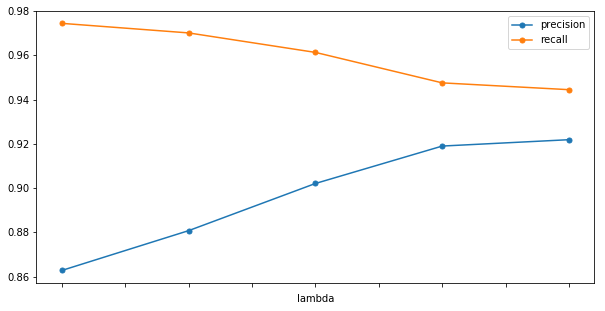

In [18]:
df_model_performance.drop('accuracy', axis=1).plot(figsize=(10,5), style='.-', ms=10)

### Predicting using lesser number of words in the vocabulary based on word count

In [19]:
%%time
best_lambda_model = models[4]
new_evaluations = []
new_evaluations.append(evaluations[4])

for i in range(9000, 0, -1000):
    new_test_results = []
    x_vocabulary_words = i
    subset_vocabulary = vocabulary[:x_vocabulary_words]
    for email in test_emails:
        new_test_results.append(predict_email(email, best_lambda_model, subset_vocabulary, x_vocabulary_words))
    new_evaluations.append(classifier_evaluation(new_test_results, true_labels))

C:\Users\Jessie\Anaconda2\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jessie\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


Wall time: 1h 23min 16s


In [20]:
df_model_performance_on_vocabulary_size = pd.DataFrame(new_evaluations, index=[i for i in range(10000, 0,-1000)])
df_model_performance_on_vocabulary_size.drop('accuracy', axis=1)

,precision,recall
10000,0.921893278142715711,0.944500783626809226
9000,0.923333033384324708,0.944756468096860313
8000,0.926482497975344210,0.943375481033534857
7000,0.927832268514352521,0.942418426103646789
6000,0.926392513272743634,0.941989203037789324
5000,0.927112390893548133,0.941257080211949537
4000,0.926302528570143058,0.939490736515469549
3000,0.923243048681724132,0.938014262205156379
2000,0.921713308737514669,0.932453345471096928
1000,0.909475389183838745,0.919152419061476933


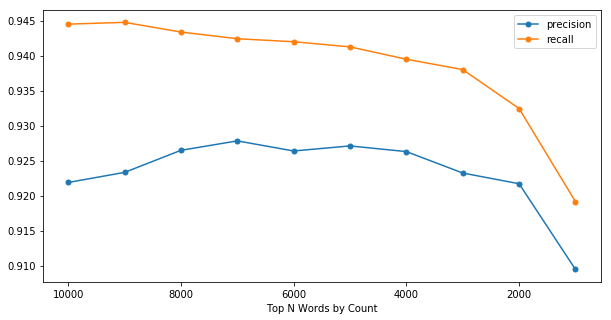

In [21]:
df_model_performance_on_vocabulary_size.sort_index(ascending=False).drop('accuracy', axis=1).plot(figsize=(10,5), style='.-', ms=10)
plt.gca().invert_xaxis()
plt.xlabel('Top N Words by Count')
plt.show()

## Improving the classifier using Mutual Information

Defining the function that computes for the mutual information scores for each word

In [22]:
def generate_mutual_information_scores(ham_emails, spam_emails, vocabulary, labels, n_words, lambda_value):
    ham_sentence_vectors = {}
    spam_sentence_vectors = {}
    
    n_vocabulary = vocabulary[:n_words]
    n_vocabulary_index = n_vocabulary.index
    
    for i in range(len(ham_emails)):
        ham_sentence_vectors[i] = sentence_vector_converter(ham_emails[i], n_vocabulary, n_words)
    
    for i in range(len(spam_emails)):
        spam_sentence_vectors[i] = sentence_vector_converter(spam_emails[i], n_vocabulary, n_words)
    
    # Creates a dataframe from the previous dictionaries that represents the classes as a matrix for easy computation
    df_ham_sentence_vectors = pd.DataFrame(ham_sentence_vectors, index = n_vocabulary_index)
    df_spam_sentence_vectors = pd.DataFrame(spam_sentence_vectors, index = n_vocabulary_index)
    
    df_all_email_vectors = pd.concat([df_ham_sentence_vectors, df_spam_sentence_vectors], axis=1)
    
    df_ham_sentence_vectors['lambda'] = [lambda_value] * n_words
    df_spam_sentence_vectors['lambda'] = [lambda_value] * n_words
    
    df_ham_conditional_probability = df_ham_sentence_vectors.sum(1).to_frame().div(float(len(all_emails)) + (lambda_value * n_words))
    df_spam_conditional_probability = df_spam_sentence_vectors.sum(1).to_frame().div(float(len(all_emails)) + (lambda_value * n_words))
    
    df_word_probabilities = df_all_email_vectors.sum(1).to_frame().div(float(len(spam_emails + ham_emails)))
    
    class_prior_probabilities = get_prior_probability_of_classes(labels)
    
    df_mutual_information_scores = ((df_ham_conditional_probability * class_prior_probabilities['ham']) * (np.log((df_ham_conditional_probability/df_word_probabilities)))) + (((1-df_ham_conditional_probability) * class_prior_probabilities['ham']) * (np.log((1-df_ham_conditional_probability)/(1-df_word_probabilities)))) + ((df_spam_conditional_probability * class_prior_probabilities['spam']) * (np.log(df_spam_conditional_probability/df_word_probabilities))) + (((1-df_spam_conditional_probability) * class_prior_probabilities['spam']) * np.log((1-df_spam_conditional_probability)/(1-df_word_probabilities)))
    
    # Compute for the mutual information
    return df_mutual_information_scores

### Retrieving the Mutual Information Scores for the words in the dictionary

In [23]:
# Generating mutual information scores
df_mutual_information_scores = generate_mutual_information_scores(ham_emails, spam_emails, vocabulary[100:10100], df_train_labels, 10000, 0.005)
df_mutual_information_scores.columns = ['scores']

# Sort the mutual information scores in descending order
df_mutual_information_scores = df_mutual_information_scores.sort_values(by='scores', ascending=False)
df_mutual_information_scores

,scores
thanks,0.054505529235934672
anyone,0.043985082793922901
handyboard,0.038922059830025814
does,0.038189015636333423
hb,0.034967425204257607
problem,0.032710795957888547
handy,0.032248608509261673
work,0.030283939635249821
ic,0.025879347178934135
t,0.023165411825642294


Top 200 words using Mutual Information

In [24]:
df_mutual_information_scores[:200].index.tolist()

['thanks',
 'anyone',
 'handyboard',
 'does',
 'hb',
 'problem',
 'handy',
 'work',
 'ic',
 't',
 'university',
 'code',
 'robot',
 'u',
 'think',
 'motor',
 'o',
 'z',
 'b',
 'two',
 'same',
 'port',
 'g',
 'good',
 'used',
 'p',
 'fred',
 'run',
 'into',
 'file',
 'want',
 'way',
 'running',
 'control',
 'tried',
 'set',
 'find',
 'ra',
 'than',
 'output',
 'seems',
 'make',
 'input',
 'motors',
 'got',
 'try',
 'where',
 'much',
 'however',
 'computer',
 'see',
 'someone',
 'had',
 'mail',
 'us',
 'problems',
 'version',
 'pm',
 'able',
 'sensor',
 'offer',
 'question',
 'here',
 'probably',
 'something',
 'trying',
 'today',
 'working',
 'first',
 'put',
 'web',
 'connect',
 'chip',
 'fine',
 'email',
 'campaign',
 'between',
 'different',
 'line',
 'go',
 'power',
 'works',
 'files',
 'hello',
 'sure',
 'digital',
 'great',
 'well',
 'voltage',
 'still',
 'inc',
 'too',
 'system',
 'advance',
 'over',
 'connected',
 'after',
 'engineering',
 'approved',
 'might',
 'sensors',
 'sou

<BarContainer object of 50 artists>

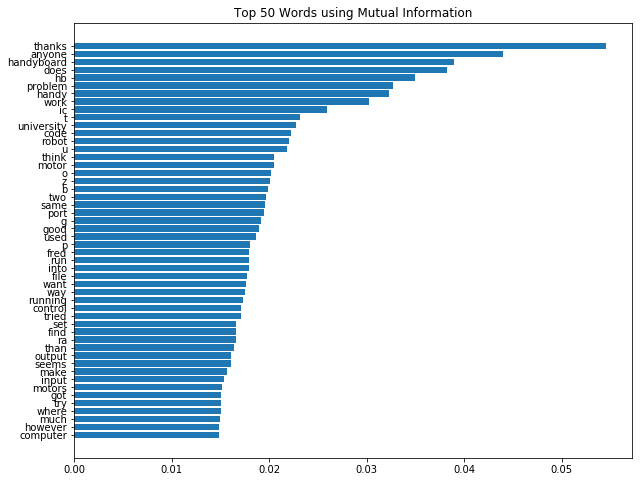

In [25]:
plt.figure(figsize=(10,8))
plt.title("Top 50 Words using Mutual Information")
plt.barh(df_mutual_information_scores[:50].sort_values(by='scores', ascending=True).index,df_mutual_information_scores[:50].sort_values(by='scores',ascending=True)['scores'].values)

<BarContainer object of 50 artists>

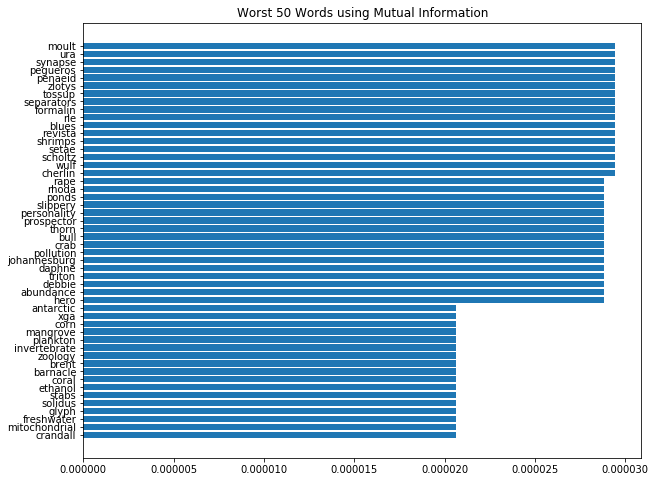

In [26]:
plt.figure(figsize=(10,8))
plt.title("Worst 50 Words using Mutual Information")
plt.barh(df_mutual_information_scores[len(df_mutual_information_scores)-50:].sort_values(by='scores', ascending=True).index,df_mutual_information_scores[len(df_mutual_information_scores)-50:].sort_values(by='scores',ascending=True)['scores'].values)

### Classification using the Top N Words using Mutual Information Scores

In [27]:
%%time
mutual_information_evaluations = []

for i in range(1000, 0, -100):
    mutual_information_results = []
    x_vocabulary_words = i
    subset_vocabulary = vocabulary.loc[df_mutual_information_scores[:x_vocabulary_words].index.tolist()]
    for email in test_emails:
        mutual_information_results.append(predict_email(email, best_lambda_model, subset_vocabulary, x_vocabulary_words))
    mutual_information_evaluations.append(classifier_evaluation(mutual_information_results, true_labels))

C:\Users\Jessie\Anaconda2\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jessie\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


Wall time: 10min 53s


In [28]:
df_mutual_information_evaluations = pd.DataFrame(mutual_information_evaluations, index=[i for i in range(1000, 0,-100)])
df_mutual_information_evaluations.drop('accuracy', axis=1)

,precision,recall
1000,0.897687393143165702,0.734609720176730541
900,0.908935480968235399,0.729841040462427704
800,0.912084945559254900,0.729261097920713697
700,0.920453522901106824,0.733682398508105016
600,0.924682803923333019,0.728535980148883322
500,0.914334563124268862,0.728073946689595908
400,0.918653828849095633,0.725895904436860029
300,0.983982722937100651,0.725421255141302956
200,0.990551606226941384,0.718022307742482546
100,0.995860703680374382,0.692813321647677505


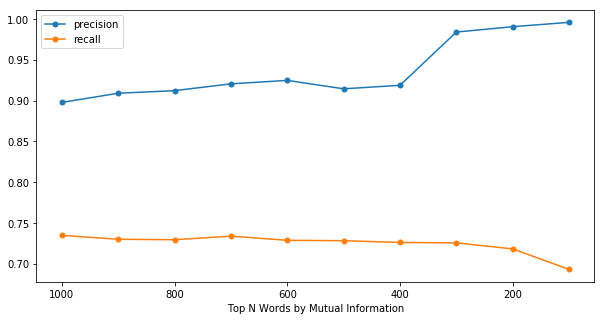

In [29]:
df_mutual_information_evaluations.sort_index(ascending=False).drop('accuracy', axis=1).plot(figsize=(10,5), style='.-', ms=10)
plt.gca().invert_xaxis()
plt.xlabel('Top N Words by Mutual Information')
plt.show()

In [39]:
investigate = best_lambda_model['model'].loc[df_mutual_information_scores[:100].index]

In [40]:
investigate.loc[investigate['ham_probabilities']>investigate['spam_probabilities']]

,ham_probabilities,spam_probabilities
thanks,0.275849069061138263,0.010993346351341578
anyone,0.223029842862802086,0.008245100166341217
handyboard,0.164268453717153068,0.000000361611340132
does,0.205599498217351129,0.010848701815288927
hb,0.148026541661164690,0.000000361611340132
problem,0.161495444341740402,0.004339697692919650
handy,0.136802456094018227,0.000000361611340132
work,0.178001452528720461,0.014175526144499892
ic,0.113033804304766936,0.000289650683445433
university,0.107883929750429153,0.001736096043971939
